# Reply Tool AB Test Post-Deployment QA

[Post-Deployment QA Task](https://phabricator.wikimedia.org/T273096) | [Enable Reply Tool AB Test Task](https://phabricator.wikimedia.org/T273554)

Instrumentation changes were deployed to make it possible to identify any non-discussion tool EditAttemptStep events by users in the AB test. These changes were deployed on 12 February 2020.

The purpose of this post-deployment QA is to confirm that events are logging as expected and needed to run the AB test.

# Requirements

* Be able to distinguish between A/B test and non-A/B test events within EditAttemptStep
* Within the Reply Tool A/B test, be able to distinguish between Discussion Tool and non-Discussion Tool events.
* Within the Reply Tool A/B test, be able to distinguish all events logged for the control group and the treatment group (This would include both Discussion Tools and VisualEditor/WikiEditor events)

In [5]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(zoo); library(lubridate)
    library(scales)
})

In [1]:
# collect all desktop edit attempts by bucket/test group and event type
query <-
"
SELECT
  date_format(dt, 'yyyy-MM-dd') as attempt_dt,
  event.bucket AS experiment_group,
  wiki As wiki,
  event.integration AS event_type,
-- review participating wikis
  IF( wiki IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki'), 'TRUE', 'FALSE'
) AS is_AB_test_wiki,
  CASE
            WHEN min(event.user_editcount) is NULL THEN 'undefined'
            WHEN min(event.user_editcount) < 100 THEN 'under 100'
            WHEN min(event.user_editcount) >=100 AND min(event.user_editcount) < 500 THEN '100-499'
            ELSE '500+'
            END AS initial_edit_count,
  event.is_oversample AS is_oversample,
  event.user_id as user_id,
  event.editing_session_id as edit_attempt_id,
  event.editor_interface AS editor_interface
FROM event.editattemptstep
WHERE
-- Review data starting a few days prior to the AB test deployment on Feb 11th
  year = 2021 
  AND month = 02
  AND day >= 06
-- look at only desktop init events
  AND event.platform = 'desktop'
  AND event.action = 'init'
  -- remove bots
  AND useragent.is_bot = false
GROUP BY
 date_format(dt, 'yyyy-MM-dd'),
 event.bucket,
 wiki,
 event.integration,
  IF( wiki IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki'), 'TRUE', 'FALSE'
    ),
  event.is_oversample,
  event.user_id,
  event.editing_session_id,
  event.editor_interface
"


In [2]:
collect_edit_attempts <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [3]:
collect_edit_attempts$attempt_dt <- as.Date(collect_edit_attempts$attempt_dt)

## Edit attempts and distinct users by experiment group

In [6]:
edit_attempts_byexperimentgroup <- collect_edit_attempts %>%
     # remove anon users and review data following AB deployment
    filter(attempt_dt >= '2021-02-12',
          user_id != 0) %>%
    group_by (is_ab_test_wiki, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

edit_attempts_byexperimentgroup 

`summarise()` regrouping output by 'is_ab_test_wiki' (override with `.groups` argument)



is_ab_test_wiki,experiment_group,n_users,n_attempts
<lgl>,<chr>,<int>,<int>
FALSE,NULL,49398,212818
TRUE,control,5751,19307
TRUE,NULL,13980,64972
TRUE,test,6338,21229


I confirmed that I can distinguish events in the AB test (indicated by `experiment_group = 'control'` or  `experiment_group = 'test'`)  and events not in the AB test (indicated by `experiment_group = 'NULL'`). 

I can also distinguish between events logged to the `Test` versus  `Control` groups within the AB test with the new instrumentation. We are logging a reasonable amount of attempts in each group among the expected experiment population.

`Control` and `Test` events are only logged for the wikis included in the AB test as expected. 

About 53.6% of all logged-in users that have attempted a desktop edit since the AB test deployment on 12 Feb 2020 on the participating wikis were not included in the AB test. Based on the AB test criteria, this would include users that have used the reply tool before (defined as people whose discussiontools-editmode preference is set). This indicates that the targeting for the A/B test is fairly restrictive.  However, even with the restrictive criteria, I believe we should have sufficient data to complete the analysis in 2 to 3 weeks based on the current rate of daily AB events logged. 


## Discussion-Tool related edit attempts and distinct users by experiment group

In [7]:
dt_attempts_byexperimentgroup <- collect_edit_attempts  %>%
 # review only AB test events
    filter(attempt_dt >= '2021-02-12',
        is_ab_test_wiki == TRUE,
          experiment_group != 'NULL',
           user_id != 0
          )  %>% 
    group_by (event_type, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

dt_attempts_byexperimentgroup

`summarise()` regrouping output by 'event_type' (override with `.groups` argument)



event_type,experiment_group,n_users,n_attempts
<chr>,<chr>,<int>,<int>
discussiontools,control,19,36
discussiontools,test,1342,3128
page,control,5744,19271
page,test,5689,18101


I confirmed I am able to distinguish between discussion tool (`event.type = 'discussiontools'`) and non-discussion tool events (`event.type = 'page'`) for both the `Test` and `Control` groups.

There are very few discussion tool attempts (36 attempts from 19 users) in the control group. This is expected as these events could only be recorded for users that manually enabled DiscussionTools. 

There is a similar number of attempts recorded for main edit attempts (`event.integration = page`) in both the test and control groups. I would expect there to be fewer non-discussion tool edit attempts in the test group compared to the control since that group is shown the reply tool as default. 

I reviewed edit attempts on talk pages only to see if some of those edits included edits to the article, where the discussion tool is not available. 


In [1]:
# review only talk page edit attempts
query <-

"
SELECT
  date_format(dt, 'yyyy-MM-dd') as attempt_dt,
  event.bucket AS experiment_group,
  wiki As wiki,
  event.integration AS event_type,
  event.init_type AS init_type,
  IF( wiki IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki'), 'TRUE', 'FALSE'
) AS is_AB_test_wiki,
  CASE
            WHEN min(event.user_editcount) is NULL THEN 'undefined'
            WHEN min(event.user_editcount) < 100 THEN 'under 100'
            WHEN min(event.user_editcount) >=100 AND min(event.user_editcount) < 500 THEN '100-499'
            ELSE '500+'
            END AS initial_edit_count,
  event.is_oversample AS is_oversample,
  event.user_id as user_id,
  event.editing_session_id as edit_attempt_id,
  event.editor_interface AS editor_interface
FROM event.editattemptstep
WHERE
-- AB test deployed on Feb 11th 
  year = 2021 
  AND month = 02
  AND day >= 12
-- look at only desktop events
  AND event.platform = 'desktop'
-- review all talk namespaces
  AND event.page_ns % 2 = 1
  AND event.action = 'init'
GROUP BY
 date_format(dt, 'yyyy-MM-dd'),
 event.bucket,
 wiki,
 event.integration,
 event.init_type,
  IF( wiki IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki'), 'TRUE', 'FALSE'
    ),
  event.is_oversample,
  event.user_id,
  event.editing_session_id,
  event.editor_interface
"


In [3]:
collect_edit_attempts_talkonly <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [6]:
dt_attempts_bytestgroup_talkpage_only <- collect_edit_attempts_talkonly  %>%
 # review only AB test events
     filter(attempt_dt >= '2021-02-12',
        is_ab_test_wiki == TRUE,
          experiment_group != 'NULL'
          )   %>% 
    group_by (event_type, init_type, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

dt_attempts_bytestgroup_talkpage_only 

`summarise()` regrouping output by 'event_type', 'init_type' (override with `.groups` argument)



event_type,init_type,experiment_group,n_users,n_attempts
<chr>,<chr>,<chr>,<int>,<int>
discussiontools,page,control,5,10
discussiontools,page,test,787,1722
page,page,control,201,292
page,page,test,205,270
page,section,control,176,255
page,section,test,143,187


ISSUE: There appear to be close to the same number of non-discussion tool edit attempts (`event.integration = 'page'`) to talk pages in both the control and test groups. I would expect there to be far fewer number of non-dt edit attempts in the test group compared to the control group as they are shown the reply tool as default. 

This could be reflective of actual user behavior. From David Lynch: "Someone who's used to replying to comments via the source editor might be sticking with what they know, rather than poking at new things. In that case, the fairly even split between control and test would be consistent with a user-type who's just not paying attention to the new functionality."

I looked at the edit count bucket splits to confirm if we see more page events in the test group for more experienced users to fit the hypothesis above:

In [21]:
dt_attempts_bytestgroup_talkpage_only_editbucket <- collect_edit_attempts_talkonly  %>%
 # review only AB test events
     filter(attempt_dt >= '2021-02-12',
        is_ab_test_wiki == TRUE,
          experiment_group != 'NULL'
          )   %>% 
    group_by (event_type, experiment_group, initial_edit_count) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

dt_attempts_bytestgroup_talkpage_only_editbucket

`summarise()` regrouping output by 'event_type', 'experiment_group' (override with `.groups` argument)



event_type,experiment_group,initial_edit_count,n_users,n_attempts
<chr>,<chr>,<chr>,<int>,<int>
discussiontools,control,under 100,5,10
discussiontools,test,100-499,82,212
discussiontools,test,500+,255,539
discussiontools,test,under 100,455,971
page,control,100-499,11,11
page,control,500+,81,166
page,control,under 100,110,115
page,test,100-499,13,16
page,test,500+,95,152


## AB Test Edit Attempts Logged by Wiki

In [299]:
ab_attempts_num_wiki <- collect_edit_attempts %>%
# review only AB edit attempts
     filter(attempt_dt >= '2021-02-12',
        is_ab_test_wiki == TRUE,
          experiment_group != 'NULL'
          )  %>%
    summarise(num_wikis = n_distinct(wiki))

ab_attempts_num_wiki

num_wikis
<int>
21


Edit attempts by users in the AB test were recorded on 21 of the 22 participating wikis. A review of attempts by each participating wikis indicates that no edit attempts by a user included in the AB test have yet been recorded on Amharic Wikipedia. As a smaller wiki, this seems possible if no user that met the AB test criteria has made an edit attempt.

In [298]:
ab_attempts_bywiki <- collect_edit_attempts %>%
# review only AB edit attempts
    filter(attempt_dt >= '2021-02-12',
            experiment_group != 'NULL',
            is_ab_test_wiki == TRUE) %>%
    group_by(wiki, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))%>%
    arrange(wiki)

ab_attempts_bywiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,experiment_group,n_users,n_attempts
<chr>,<chr>,<int>,<int>
afwiki,control,3,14
afwiki,test,6,18
arzwiki,control,1,1
arzwiki,test,3,5
bnwiki,control,29,70
bnwiki,test,19,53
eswiki,control,520,1181
eswiki,test,585,1406
fawiki,control,134,367


There are no large discrepancies between the number of unique users that made an edit attempt in the control and test groups on each wiki as expected if 50% of users were randomly assigned to each bucket.

Note: I reviewed the mediawiki user preferences table to confirm that users in each wiki were bucketed appropriately based on the `dicussiontools-abtest` preference and value. See further details in [T268193#6781374](https://phabricator.wikimedia.org/T268193#6781374).


## AB Test Edit Attempts by User Edit Count

In [300]:
ab_attempts_byeditcount <- collect_edit_attempts %>%
# review only AB edit attempts
    filter(attempt_dt >= '2021-02-12',
            experiment_group != 'NULL',
            is_ab_test_wiki == TRUE) %>%
    group_by(experiment_group, initial_edit_count) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

ab_attempts_byeditcount 

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,initial_edit_count,n_users,n_attempts
<chr>,<chr>,<int>,<int>
control,100-499,316,838
control,500+,1340,4601
control,under 100,1825,3104
test,100-499,364,999
test,500+,1355,5000
test,under 100,2132,4243


We are logging a reasonable amount of attempts in each edit count group for each test group across all participating wikis. 

Currently, we have edit attempts from the most unique users in the under 100 edits edit bucket  for both AB experiment groups. However, we are currently logging the most attempts from senior contributors with over 500 edits.

## AB Test Edit Attempts by Logged In Status

In [ ]:
reply_ab_events_byloggedin <- collect_edit_attempts %>%
    filter(attempt_dt >= '2021-02-12',
            is_ab_test_wiki == TRUE,
          test_group != 'NULL')  %>% 
    mutate(logged_in_status = ifelse(user_id == 0, 'logged-out', 'logged-in')) %>% 
    filter(logged_in_status == 'logged-out') %>% 
    group_by (wiki,test_group, initial_edit_count) %>%
    summarise(users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

reply_ab_events_byloggedin 

I confirmed that there are no edit attempts from logged out users recorded as part of the AB test. 

## AB Test Edit Attempts by Editing Interface

In [232]:
reply_ab_events_byinterface <- collect_edit_attempts %>%
    filter(attempt_dt >= '2021-02-12',
            is_ab_test_wiki == TRUE,
          test_group != 'NULL')  %>%  
    group_by (test_group, editor_interface) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

reply_ab_events_byinterface 

`summarise()` regrouping output by 'test_group' (override with `.groups` argument)



test_group,editor_interface,n_users,n_attempts
<chr>,<chr>,<int>,<int>
control,visualeditor,1478,2649
control,wikitext,1348,3083
control,wikitext-2017,49,125
test,visualeditor,1754,3781
test,wikitext,1577,3678
test,wikitext-2017,44,110


Events from all three editor interface types (visualeditor, wikitext, and wikitext-2017) were recorded for each test group type as expected. 

## Discussion tool events without oversampling change

All of the data reported above in this report included the oversampling of discussion tool related events, which was deployed along with the other instrumentation changes on 12 February 2020.

I reviewed edit attempts by oversampling status to confirm if this change was deployed correctly to all dt-related events.

In [301]:
# review edit attempts by oversample status
edit_attempts_by_oversample <- collect_edit_attempts %>%
    group_by (experiment_group, is_oversample) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

editattempts_by_oversample

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



test_group,is_oversample,n_users,n_attempts
<chr>,<chr>,<int>,<int>
control,false,2641,5707
control,true,98,149
NULL,false,73685,329915
NULL,true,1348,5530
test,false,2586,5726
test,true,851,1844


Oversampled events are recorded for each experiment group type.
Now let's review discussion tool events by oversample status.

In [302]:
dt_attempts_by_oversample <- collect_edit_attempts  %>%
    filter(user_id != 0)  %>% 
    group_by (event_type, is_oversample) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id))

editattempts_bydtevents_by_oversample

`summarise()` regrouping output by 'event_type' (override with `.groups` argument)



event_type,is_oversample,n_users,n_attempts
<chr>,<chr>,<int>,<int>
discussiontools,false,217,387
discussiontools,true,1510,5940
page,false,46210,164384
page,true,404,824


I confirmed that we are oversampling discussiontool events. There are also some non discussion tool events (`event.type = page`) we are still oversampling.

In [303]:
# daily discussion tool edits attempts by oversample

dt_events_daily <- collect_edit_attempts %>%
    filter(event_type == 'discussiontools') %>%
    group_by(attempt_dt, is_oversample)  %>%
    summarize(n_attempts = n_distinct(edit_attempt_id))


`summarise()` regrouping output by 'attempt_dt' (override with `.groups` argument)



Warning message:
“Removed 2 rows containing missing values (geom_vline).”


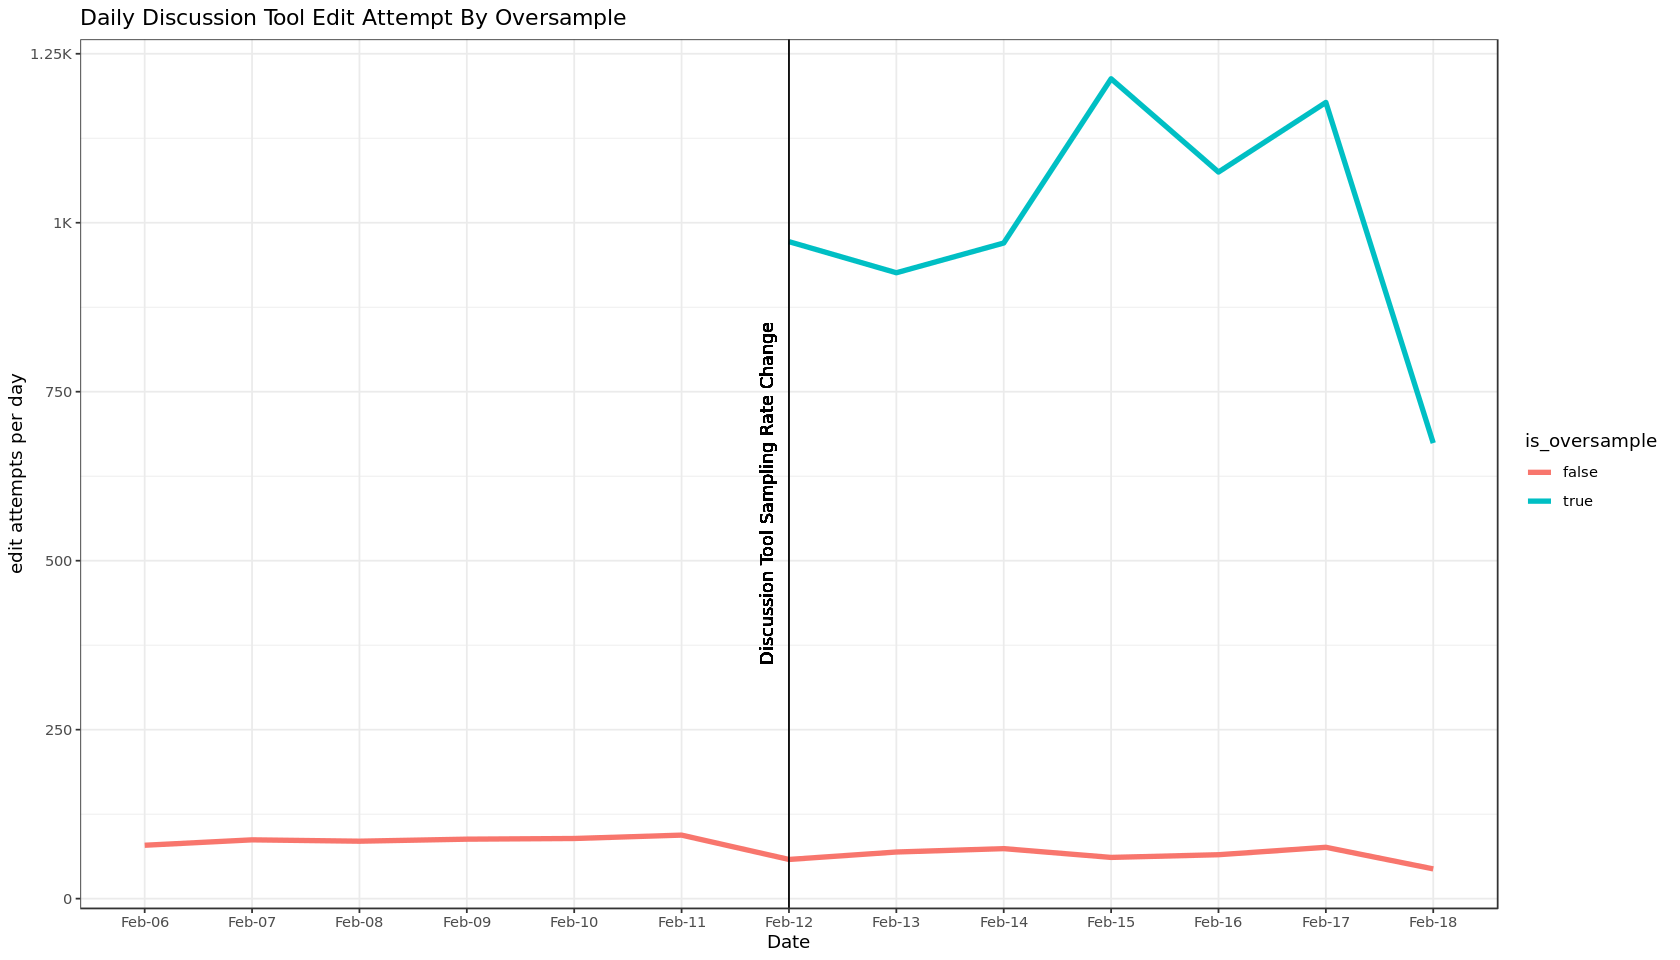

In [304]:
# plot daily dt events
options(repr.plot.width = 14, repr.plot.height = 8)

p <- dt_events_daily %>%
    ggplot(aes(x= attempt_dt, y= n_attempts, color = is_oversample)) +
    geom_line(size = 1.5) +
    geom_vline(xintercept =  as.numeric(as.Date(c('2021-02-12', linetype = "dashed", color = "black")))) +
    geom_text(aes(x=as.Date('2021-02-12'), y=600, label="Discussion Tool Sampling Rate Change"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 day", minor_breaks = NULL) +
    scale_y_continuous(labels = polloi::compress) +
    labs(
    x = 'Date', y = "edit attempts per day",
    title = "Daily Discussion Tool Edit Attempt By Oversample"
 ) +
  theme(legend.position = "bottom",
       text = element_text(size=20)) + 
  theme_bw() 
    

p

The plot above show that discussion tool events are oversampled starting on 12 Feb 2021 following the deployment of the config change. The increase in dt events fits with a sampling rate change of 100%.